# Приоритизация гипотез и анализ результатов A/B-теста в интернет-магазине.

## Описание проекта  
В нашем распоряжении файл со списокм гипотез для увеличения выручки интернет-магазина и два файла с результатами A/B-теста.  

**Описание файлов:**  

Файл **`hypothesis.csv`**.
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл **`orders.csv`**.
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.  

Файл **`visitors.csv`**.
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

**Цель исследования:** приоритизировать гипотезы и проанализировать результаты A/B-теста.  

**План проведения исследования:**  
- загрузить и изучить имеющиеся данные,
- провести приоритизацию гипотез методами ICE и RICE,
- провести предварительную обработку данных,
- построить график кумулятивной выручки по группам,
- построить график кумулятивного среднего чека по группам,
- построить график относительного изменения кумулятивного среднего чека группы B к группе A,
- построить график кумулятивного среднего количества заказов на посетителя по группам,
- построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A,
- построить точечный график количества заказов по пользователям,
- посчитать 95-й и 99-й перцентили количества заказов на пользователя и выбрать границу для определения аномальных пользователей,
- построить точечный график стоимостей заказов,
- посчитать 95-й и 99-й перцентили стоимости заказов и выбрать границу для определения аномальных заказов,
- посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным,
- посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным,
- посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным,
- посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным,
- принять решение по результатам теста.

## Базовый анализ данных  

Рассмотрим имеющиеся файлы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
# установим формат отображения вещественных чисел - 2 знака после запятой
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# увеличим количество отображаемых символов в датафреймах до 120
pd.set_option('display.max_colwidth', 120)

In [ ]:
try:
    df = pd.read_csv('/datasets/hypothesis.csv')

except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пустой или не содержит данных")
except pd.errors.ParserError:
    print("Ошибка при чтении файла")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [ ]:
# приведем названия колонок к нижнему регистру
df = df.rename(columns=str.lower)
df

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В датафрейме с гипотезами 5 колонок и 9 строк.  
Названия колонок привели в формат snake_case.  
Типы данных корректные.  
Пропусков, дубликатов и подозрительных значений нет.

In [ ]:
# Прочитаем файл и сразу приведем даты к формату "datetime".
try:
    orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])

except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пустой или не содержит данных")
except pd.errors.ParserError:
    print("Ошибка при чтении файла")

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [ ]:
# приведем названия колонок к snake_case
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [ ]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [ ]:
print('Количество строк-дубликатов:', orders.duplicated().sum())

Количество строк-дубликатов: 0


In [ ]:
orders['revenue'].describe()

count      1197.00
mean       8348.01
std       39191.13
min          50.00
25%        1220.00
50%        2978.00
75%        8290.00
max     1294500.00
Name: revenue, dtype: float64

In [ ]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [ ]:
print('Начальная дата периода:', orders['date'].min())
print('Конечная дата периода:', orders['date'].max())

Начальная дата периода: 2019-08-01 00:00:00
Конечная дата периода: 2019-08-31 00:00:00


В датафрейме с заказами 5 колонок и 1197 строк.  
Тип данных колонки с датами скорректировали на "datetime". Остальные типы данных правильные.  
Названия колонок привели в формат snake_case.  
Пропусков, дубликатов и подозрительных значений нет.

In [ ]:
# Прочитаем файл и сразу приведем даты к формату "datetime".
try:
    visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пустой или не содержит данных")
except pd.errors.ParserError:
    print("Ошибка при чтении файла")

In [ ]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [ ]:
print('Количество строк-дубликатов:', visitors.duplicated().sum())

Количество строк-дубликатов: 0


In [ ]:
visitors['visitors'].describe()

count    62.00
mean    607.29
std     114.40
min     361.00
25%     534.00
50%     624.50
75%     710.50
max     770.00
Name: visitors, dtype: float64

In [ ]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [ ]:
print('Начальная дата периода:', visitors['date'].min())
print('Конечная дата периода:', visitors['date'].max())

Начальная дата периода: 2019-08-01 00:00:00
Конечная дата периода: 2019-08-31 00:00:00


В датафрейме с количеством пользователей 3 колонки и 62 строки.  
Тип данных колонки с датами скорректировали на "datetime". Остальные типы данных правильные.  
Пропусков, дубликатов и подозрительных значений нет.

**Резюме подраздела:**  
Мы загрузили и ознакомились с данными:
- исследуемый период - с 1 августа 2019 г. по 31 августа 20219 г.
- пропущенных значений нет,
- строк-дубликатов нет,
- неявных дубликатов в категориальных переменных нет,
- подозрительных значений в количественных переменных нет,
- тип данных в колонках с датами исправили на "datetime". Остальные типы данных корректные,
- названия колонок привели в формат snake_case.

## Проведем приоритизацию гипотез

### Применим фреймворк "ICE"

In [ ]:
df['ICE'] = df['impact'] * df['confidence'] / df['efforts']

display(df[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Согласно этому методу, наиболее приоритетная гипотеза - _"Запустить акцию, дающую скидку на товар в день рождения"_

### Применим фреймворк "RICE"

In [ ]:
df['RICE'] = df['reach'] * df['impact'] * df['confidence'] / df['efforts']

display(df[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


При анализе этим методом, гипотеза об акции на скидку в день рождения опускается на пятое место, а наиболее приоритетной оказывается гипотеза _"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"_.   

Это можно объяснить тем, что во фреймворке "RICE" мы дополнительно используем еще один аргумент - "Reach", который для данной гипотезы имеет максимальное значение и, соответственно, придает ей больший вес.

### Определим самые приоритетные гипотезы

Проранжируем гипотезы в зависимости от количества набранных очков обоими методами.  
Затем суммируем ранги и определим, у каких гипотез наибольший суммарный ранг.  
Это и будут наиболее приоритетные гипотезы, рассчитанные обоими методами.

In [ ]:
df['rank_ICE'] = df['ICE'].rank()
df['rank_RICE'] = df['RICE'].rank()
df['rank_total'] = df['rank_ICE'] + df['rank_RICE']
df = df.sort_values(by='rank_total', ascending=False)
df[['hypothesis', 'rank_total']]

,hypothesis,rank_total
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",16.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",14.50
8,"Запустить акцию, дающую скидку на товар в день рождения",14.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",13.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",12.50
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",6.50
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",6.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",5.50
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",2.00


**Резюме подраздела:**  

Мы определили топ-3 наиболее приоритетных гипотезы по результатам расчетов методами "ICE" и "RICE":
1. _Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок._
2. _Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей._
3. _Запустить акцию, дающую скидку на товар в день рождения._

## Проведем предварительную обработку данных

### Создадим датафрейм для построения графиков.

In [ ]:
# создаем массив уникальных пар значений дат и групп
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах:
- получим строки таблицы `orders`, дата которых меньше или равна дате элемента из `datesGroups`, а группа теста равна группе из `datesGroups`,
- агрегируем нужные нам значения,
- применим методы к каждой строке датафрейма, указав `axis=1`,
- отсортируем результаты по столбцам `date` и `group`.

In [ ]:
ordersAggregated = datesGroups \
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
.sort_values(by=['date','group'])

Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина.

In [ ]:
visitorsAggregated = datesGroups. \
apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
.sort_values(by=['date','group'])

In [ ]:
print('Количество строк датафрейма с заказами:', ordersAggregated.shape[0])
print('Количество строк датафрейма с посетителями:', visitorsAggregated.shape[0])

Количество строк датафрейма с заказами: 62
Количество строк датафрейма с посетителями: 62


In [ ]:
# ъединим обе таблицы в одну и переименуем названия колонок.
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [ ]:
print('Количество строк объединенного датафрейма:',cumulativeData.shape[0])
print('Пропущенных значений:', cumulativeData.isna().sum().sum())
print('Начальная дата в объединенном датафрейме', cumulativeData['date'].min())
print('Конечная дата в объединенном датафрейме', cumulativeData['date'].max())

Количество строк объединенного датафрейма: 62
Пропущенных значений: 0
Начальная дата в объединенном датафрейме 2019-08-01 00:00:00
Конечная дата в объединенном датафрейме 2019-08-31 00:00:00


Количество строк начальных датафреймов совпадает с количеством строк объединенного датафрейма.  
Начальная и конечная даты совпадают с датами в исходных данных.  
Пропусков нет.  
Датафрейм создан корректно.

### Создадим датафрейм для расчета статистической значимости.

In [ ]:
# посчитаем количество посетителей из контрольной группы в каждый день
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# посчитаем кумулятивную сумму количества посетителей контрольной группы
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']] \
                                                .agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1,)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# посчитаем количество посетителей из тестовой группы в каждый день
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# посчитаем кумулятивную сумму количества посетителей тестовой группы
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']] \
                                            .agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# считаем для контрольной группы количество заказов и выручку за каждый день
ordersADaily = (orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']] \
                                            .groupby('date', as_index=False) \
                                            .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# считаем для контрольной группы кумулятивную сумму количества заказов и выручки
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']] \
                                            .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1,)\
                                            .sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA',]

# считаем для тестовой группы количество заказов и выручку за каждый день
ordersBDaily = (orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']] \
                                            .groupby('date', as_index=False) \
                                            .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# считаем для тестовой группы кумулятивную сумму количества заказов и выручки
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']] \
                                            .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1,) \
                                            .sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB',]

# объединим все постоенные датафреймы в один
data = (ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


**Резюме подраздела:**  

Мы составили датафреймы с кумулятивными значениями различных параметров, на основании которых можно строить графики и считать статистическую значимость.

## Проведем анализ A/B-теста

### Построим график кумулятивной выручки по группам.

In [ ]:
# глобально зададим размер всех графиков
plt.rcParams['figure.figsize'] = (9, 4)

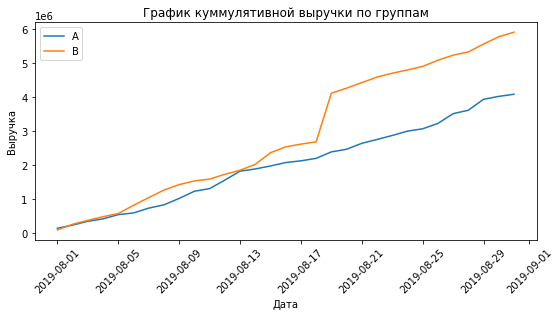

In [ ]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График куммулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=45)

plt.legend()
plt.show()

Кумулятивная выручка контрольной группы (группы А) растет плавно, а у тестовой группы (группы В) виден резкий рост в период с 17 по 21 августа.  
Это может говорить о всплеске количества заказов или о появлении аномально дорогих заказов в этот период.

### Построим график кумулятивного среднего чека по группам.  

Для этого разделим кумулятивную выручку на кумулятивное число заказов.

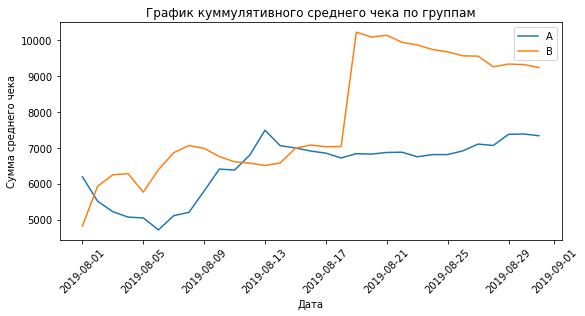

In [ ]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График куммулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.xticks(rotation=45)

plt.legend()
plt.show()

Средний чек контрольной группы после провала в начале месяца стабилизировался и примерно с 13 августа сохранял относительно нейтральную динамику.  
Средний чек тестовой группы скачкообразно увеличивался в начале месяца. С 17 по 21 августа виден особенно резкий скачок.
Очевидно, в этот период были покупки на аномально большие суммы.  
В дальнейшем значение среднего чека по этой группе приняло плавный нисходящий характер.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

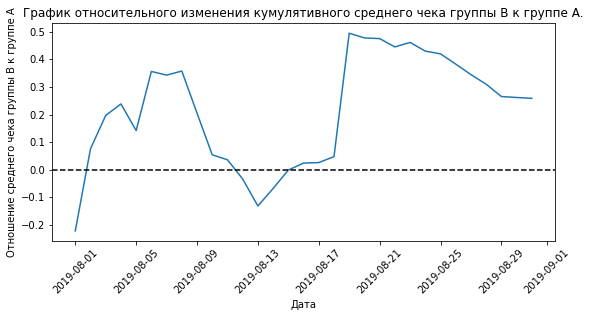

In [ ]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left',
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'],
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A.')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека группы B к группе A')
plt.xticks(rotation=45)

plt.show()

На графике мы видим два пика - в периоды с 5 по 9 августа и с 17 по 21 августа. В эти периоды клиенты тестовой группы покупали на  существенно большие суммы, чем клиенты контрольной группы. Еще одно доказательство в пользу наличия выбросов в виде покупок на аномально высокие суммы.

### Построим график кумулятивного среднего количества заказов на посетителя по группам  

Отношение кумулятивного среднего количества заказов к кумулятивному количеству посетителей по сути представляет собой кумулятивную конверсию.

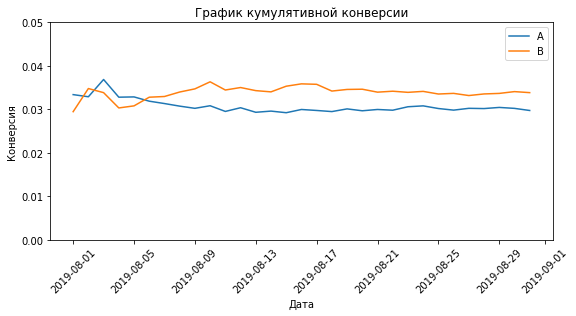

In [ ]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# разделяем ее по группам
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.legend()
plt.title('График кумулятивной конверсии')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=45)

# зададим масштаба оси ординат
plt.ylim(0, 0.05)

plt.show()

После некоторых колебаний в начале месяца, конверсии стабилизировались к 10-м числам августа. Причем конверсия тестовой группы осталась стабильно выше конверсии контрольной группы.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

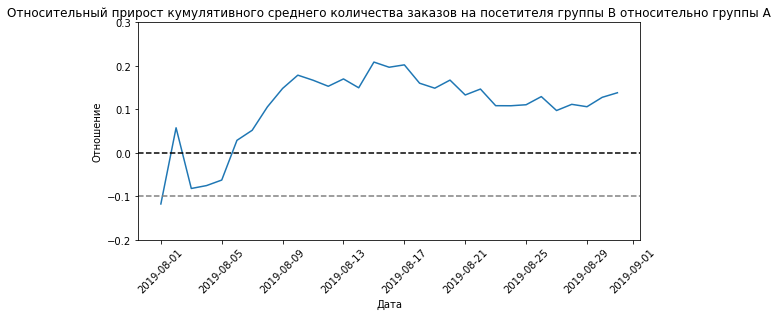

In [ ]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']] \
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title("Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.xlabel('Дата')
plt.ylabel('Отношение')
plt.ylim(-0.2, 0.3)
plt.xticks(rotation=45)

plt.show()

После неопределенности в течение первой недели, конверсия тестовой группы уверенно опережает конверсию контрольной группы на 10-20%. Имеются признаки стабилизации.

### Построим точечный график количества заказов по пользователям.

In [ ]:
# сгруппируем данные по пользователям и посчитаем количество заказов
ordersByUsers = orders.groupby('visitor_id', as_index=False) \
.agg({'transaction_id': 'nunique'}) \
.sort_values(by='transaction_id', ascending=False)

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.head()

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


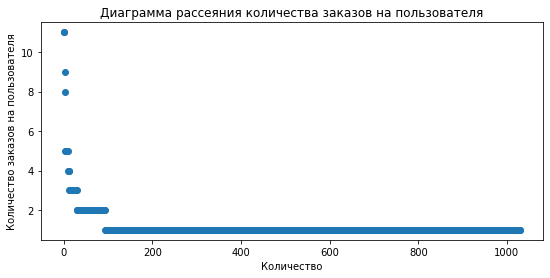

In [ ]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title("Диаграмма рассеяния количества заказов на пользователя")
plt.xlabel('Количество')
plt.ylabel('Количество заказов на пользователя')

plt.show()

На графике мы видим, что те пользователи, которые делали заказы, в своем большинстве совершали только один заказ.  
Но мы также видим, что есть пользователи, которые совершали большое количество заказов - вплоть до 11.

### Посчитаем 95-й и 99-й перцентили количества заказов по пользователям.

In [ ]:
print('95-й перцентиль стоимости заказов равен', np.percentile(ordersByUsers['orders'], 95))
print('99-й перцентиль стоимости заказов равен', np.percentile(ordersByUsers['orders'], 99))

95-й перцентиль стоимости заказов равен 2.0
99-й перцентиль стоимости заказов равен 4.0


In [ ]:

print('Количество пользователей с 2 и более заказами:', len(ordersByUsers[ordersByUsers['orders'] >= 2]))
print('Количество пользователей с 4 и более заказами:', len(ordersByUsers[ordersByUsers['orders'] >= 4]))

Количество пользователей с 2 и более заказами: 94
Количество пользователей с 4 и более заказами: 13


За аномалии можем принять пользователей с 4 и более заказами. Таких всего 13.

### Построим точечный график стоимостей заказов.

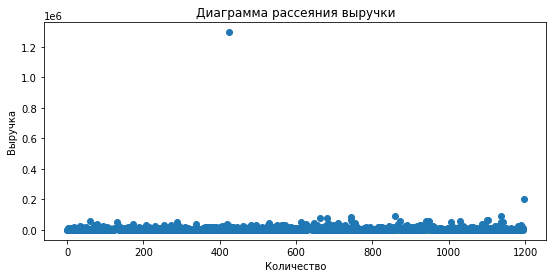

In [ ]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])
plt.title("Диаграмма рассеяния выручки")
plt.xlabel('Количество')
plt.ylabel('Выручка')

plt.show()

Мы видим выбивающиеся из общей массы значения.  
Одно из значений расположено крайне далеко от общей массы. Это заказ на экстремально высокую сумму. Похоже, именно он обусловил скачки на графиках выручки и среднего чека в пользу тестовой группы, которые мы видели ранее.

### Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [ ]:
print('95-й перцентиль стоимости заказов равен', round(np.percentile(orders['revenue'], 95)))
print('99-й перцентиль стоимости заказов равен', round(np.percentile(orders['revenue'], 99)))

95-й перцентиль стоимости заказов равен 28000
99-й перцентиль стоимости заказов равен 58233


In [ ]:
print('Количество заказов дороже 28000:', len(orders[orders['revenue'] > 28000]))
print('Количество заказов дороже 58233:', len(orders[orders['revenue'] > 58233]))

Количество заказов дороже 28000: 60
Количество заказов дороже 58233: 12


При знакомстве с данними мы видели, что среднее значение выручки почти в 3 раза превышает медиану. Это говорит о крайне сильном влиянии выбросов. Как правило, отсеивают от 1% до 5% наблюдений с крайними значениями. В данном случае видится разумным взять границу в 5% и принять за аномалии выручку, превышающую 28000.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем гипотезы.  
H0: нет различий в среднем количестве заказов между группами.   
H1: есть различия в среднем количестве заказовмежду группами.

In [ ]:
# посчитаем количество заказов для пользоватлей контрольной группы
ordersByUsersA = (orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique}))
ordersByUsersA.columns = ['visitor_id', 'orders']

# посчитаем количество заказов для пользоватлей тестовой группы
ordersByUsersB = (orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique}))
ordersByUsersB.columns = ['visitor_id', 'orders']

# создадим список из количества заказов пользователей контрольной группы
# и добавим в него пользователей, которые не совершили ни одного заказа.
sampleA = pd.concat([ordersByUsersA['orders'],
                    pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                    name='orders', ), ], axis=0,)

sampleB = pd.concat([ordersByUsersB['orders'],
                    pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                    name='orders', ), ], axis=0,)

# зададим уровень статистической значимости
alpha = 0.05

# рассчитаем статистический критерий методом Манна-Уитни
pvalue = stats.mannwhitneyu(sampleA, sampleB)[1]

print('pvalue =', "{0:.3f}".format(pvalue))
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print()
print('Относительное различие между тестовой и контрольной группами:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


pvalue = 0.017
Отвергаем нулевую гипотезу: разница статистически значима

Относительное различие между тестовой и контрольной группами: 0.138


При расчете по неочищенным данным мы получили p-значение меньше критического уровня статистической значимости.  
Мы отвергаем нулевую гипотезу о равенстве и у нас есть основания утверждать, что различия в среднем количестве заказов на посетителя между обеими группами статистически значимы.  
Среднее значение количества заказов тестовой группы больше среднего значения количества заказов контрольной группы на 13,8%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.  

Сформулируем гипотезы:  
H0: нет различий в среднем чеке заказа между группами.   
H1: есть различия в среднем чеке заказа между группами.

In [ ]:
revenueA = orders[orders['group']=='A']['revenue']
revenueB = orders[orders['group']=='B']['revenue']

pvalue = stats.mannwhitneyu(revenueA, revenueB)[1]

print('pvalue =', "{0:.3f}".format(pvalue))
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print()
print('Относительное различие между тестовой и контрольной группами:', "{0:.3f}".format(revenueB.mean() / revenueA.mean() - 1))

pvalue = 0.729
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительное различие между тестовой и контрольной группами: 0.259


Согласно нашим расчетам, нет оснований отвергать нулевую гипотезу. Мы можем сделать умозаключение, что средние чеки контрольной и тестовой групп не имеют статистически значимых отличий.  
Среднее значение всех средних чеков тестовой группы превышает аналогичный показатель контрольной группы на внушительные 25,9%, но, как мы установили ранее, на среднее значение чеков тестовой группы оказал большое влияние выброс в виде экстремально большого заказа.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Создадим вспомогательный датафрейм с данными, которые мы признали выбросами:  
- количество заказов на одного пользователя = 4 и более,
- стоимость заказа более 28000.

In [ ]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] >= 4]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] >= 4]['visitor_id'],], axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']

abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())

print(abnormalUsers.head(5))
print()
print('Количество аномальных пользователей:', abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitor_id, dtype: int64

Количество аномальных пользователей: 63


Оценим влияние аномальных пользователей на результаты A/B-теста.  
Гипотезы оставим те же:  
H0: нет различий в среднем количестве заказов между группами.   
H1: есть различия в среднем количестве заказовмежду группами.

In [ ]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)


pvalue = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

print('pvalue =', "{0:.3f}".format(pvalue))
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print()
print('Относительное различие между тестовой и контрольной группами:', "{0:.3f}"
      .format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))


pvalue = 0.018
Отвергаем нулевую гипотезу: разница статистически значима

Относительное различие между тестовой и контрольной группами: 0.148


Результат практически не изменился - p-значение осталось примерно на том же уровне, меншим, чем уровень статистической значимости. Поэтому мы и после фильтрации выбросов отвергаем нулевую гипотезу и можем приять, что различия между количествами заказов в двух группах статистически значима.  
Среднее значение количества заказов тестовой группы в данном случае увеличилось на 1% по отношению к контрольной группе и составило 14,8%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Гипотезы:  
H0: нет различий в среднем чеке заказа между группами.   
H1: есть различия в среднем чеке заказа между группами.

In [ ]:
revenueA_filt = orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue']
revenueB_filt = orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue']

pvalue = stats.mannwhitneyu(revenueA_filt, revenueB_filt)[1]

print('pvalue =', "{0:.3f}".format(pvalue))
if pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print()
print('Относительное различие между тестовой и контрольной группами:',
      "{0:.3f}".format(revenueB_filt.mean() / revenueA_filt.mean() - 1))

pvalue = 0.977
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительное различие между тестовой и контрольной группами: -0.017


После фильтрации выбросов p-значение заметно увеличилось и результат остался тем же - мы не отвергаем нулевую гипотезу и считаем, что между средними чеками обеих групп нет статистически значимой разницы.  
Мы также видим, что относительная разница между средними значениями средних чеков тестовой группы существенно снизилась и стала меньше, чем в контрольной группе на 1,7%.  
Можем сделать вывод, что выбросы в величинах средних чеков имеют намного большее влияние и намного сильнее искажают результаты расчетов, чем выбросы в количествах заказов на одного пользователя.

## Выводы

- Есть статистически значимые различия в среднем количестве заказов на посетителя между обеими группами по "сырым" и "очищенным" данным.  
- Нет статистически значимых различий в среднем чеке заказа между обеими группами по "сырым" и "очищенным" данным.  
- На графике относительного различия среднего количества заказов между группами видим, что результаты тестовой группы во второй половине анализируемого периода лучше контрольной группы и в последние дни наблюдаются признаки стабилизации.
- График относительного различия среднего чека между группами свидетельствует о том, что результаты тестовой группы лучше результатов контрольной группы и в последнюю неделю анализируемого периода видны признаки стабилизации.
- Выбросы в величинах средних чеков имеют намного большее влияние и намного сильнее искажают результаты расчетов, чем выбросы в количествах заказов на одного пользователя.
- Мы можем остановить тест, признать его успешным и зафиксировать победу тестовой группы, поскольку у нас есть основания заявить, тестируемое изменение привело к статистически значимому росту количества заказов на посетителя. В свою очередь рост количества заказов оказывает благоприятное влияние на выручку.